In [3]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def load_image(image_path):
    max_dim = 512
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def show_image(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

def save_image(image, filename):
  """Saves the image to a file with the given filename."""
  image = image.numpy()
  image = np.array(image * 255, dtype=np.uint8)  # Convert to uint8 for PIL
  image = Image.fromarray(image)
  image.save(filename)

def get_model():
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    content_layers = ['block5_conv2']
    outputs = [vgg.get_layer(name).output for name in style_layers + content_layers]
    return tf.keras.Model(inputs=vgg.input, outputs=outputs)

def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(tf.shape(a)[0], tf.float32)

def total_variation_loss(image):
    return tf.reduce_sum(tf.image.total_variation(image))

def compute_loss(outputs, content_targets, style_targets, target_image, style_weight, content_weight, tv_weight):
    style_outputs = outputs[:len(style_targets)]
    content_outputs = outputs[len(style_targets):]
    style_score = sum(style_weight * tf.reduce_mean((gram_matrix(style_output) - target)**2) for style_output, target in zip(style_outputs, style_targets))
    content_score = sum(content_weight * tf.reduce_mean((content_output - target)**2) for content_output, target in zip(content_outputs, content_targets))
    tv_loss = total_variation_loss(target_image)
    return style_score + content_score + tv_weight * tv_loss

def run_style_transfer(content_path, style_path, num_iterations, style_weight, content_weight, tv_weight):
    model = get_model()
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.02, beta_1=0.99, epsilon=0.1)
    target_image = tf.Variable(load_image(content_path))
    content_image = load_image(content_path)
    style_image = load_image(style_path)
    style_features = model(style_image)
    content_features = model(content_image)
    style_targets = [gram_matrix(feature) for feature in style_features]
    content_targets = [feature for feature in content_features]
    for i in range(num_iterations):
        with tf.GradientTape() as tape:
            outputs = model(target_image)
            loss = compute_loss(outputs, content_targets, style_targets, target_image, style_weight, content_weight, tv_weight)
        grad = tape.gradient(loss, target_image)
        optimizer.apply_gradients([(grad, target_image)])
        target_image.assign(tf.clip_by_value(target_image, 0.0, 1.0))
        if i % 100 == 0:
            print(f"Iteration: {i}, Loss: {loss.numpy()}, Style Weight: {style_weight}, Content Weight: {content_weight}")
            show_image(target_image.read_value())
    show_image(target_image.read_value())

Iteration: 0, Loss: 150.54034423828125, Style Weight: 0.01, Content Weight: 100000


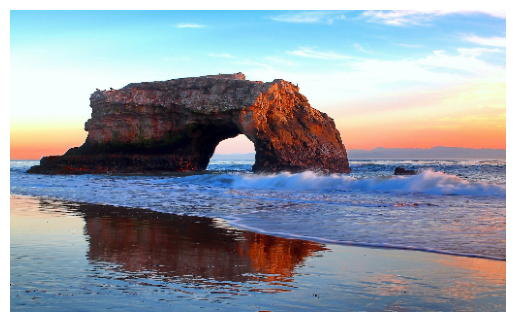

Iteration: 100, Loss: 33.6253547668457, Style Weight: 0.01, Content Weight: 100000


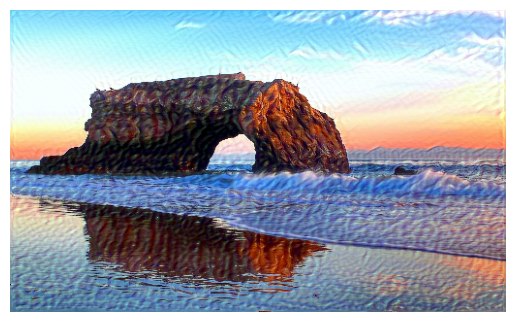

Iteration: 200, Loss: 10.142252922058105, Style Weight: 0.01, Content Weight: 100000


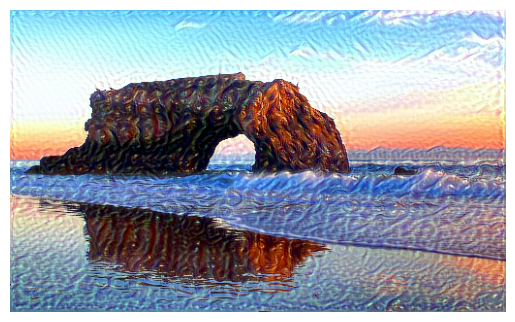

Iteration: 300, Loss: 5.366048812866211, Style Weight: 0.01, Content Weight: 100000


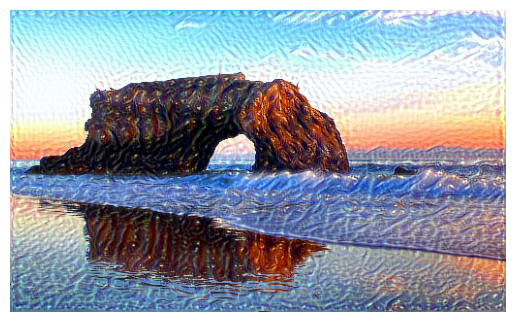

Iteration: 400, Loss: 3.3912675380706787, Style Weight: 0.01, Content Weight: 100000


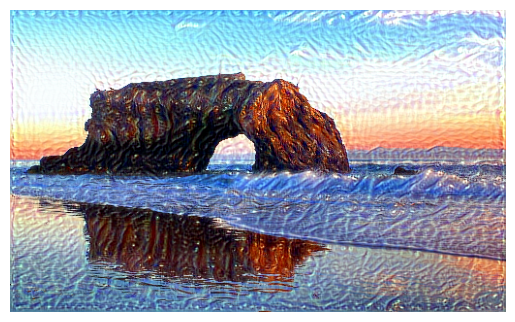

Iteration: 500, Loss: 2.3822412490844727, Style Weight: 0.01, Content Weight: 100000


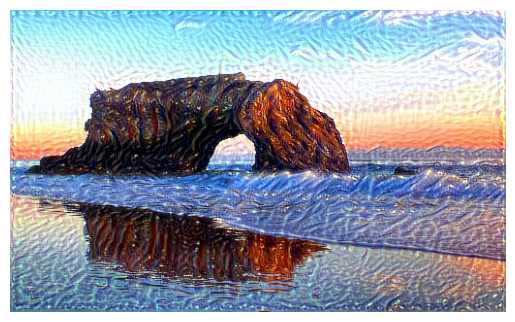

Iteration: 600, Loss: 1.8289005756378174, Style Weight: 0.01, Content Weight: 100000


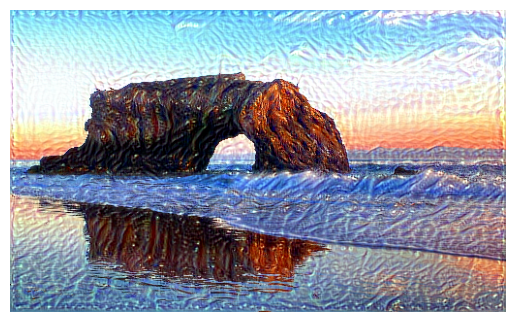

In [ ]:
run_style_transfer('content04.jpg', 'style05.jpg', num_iterations=1000, style_weight=0.01, content_weight=100000, tv_weight=0)